In [209]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report,f1_score
import preprocessor as p
import gensim
import gensim.downloader as gensim_api

In [210]:
#!pip install -U wordcloud
#!pip install -U plotly plotly-express
#!pip install -U spacy
## for word embedding
#!pip install -U gensim
#!pip install tweet-preprocessor
# nlp = spacy.load('en_core_web_sm')
import nltk
# nltk.download('wordnet')

In [211]:
# Importing the training dataset
DATASET_COLUMNS=['id','label','tweet']
df_train = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv', names=DATASET_COLUMNS, header=0)
df_train.sample(5)

,id,label,tweet
14181,14182,0,so i don't have time to train for the 3 disciplines of triathlon so why wouldn't i enter a race with 4! #quad #bettergetpaddling ð
21482,21483,0,finding life inside the illusion. for d lack of any other choice.
12979,12980,1,stop calling @user ! i've met him. bbc is more than he. he's got big work ahead. @user @user
11399,11400,0,"@user @user me to, i sure miss the old amarillo. ð"
24177,24178,0,#goodmorning ð¤ð¤ #gm#haveaniceday#like4like#l4l#sea#sun#hello #friday


In [212]:
#Length of the dataset

print('length of train data is', len(df_train))
df_train.describe()

length of train data is 31962


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [213]:
# Importing the Testing dataset
DATASET_COLUMNS=['id','tweet']
df_test = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/test_tweets_anuFYb8.csv', names=DATASET_COLUMNS,header=0)
df_test.sample(5)

,id,tweet
6258,38221,"i don't understand?! milner, henderson, wilshere.... leave vardy off the pitch? no logic whatsoever. negative, negative roy #euro2016"
16577,48540,- sirf ashiq log follow karen #iqbal #galib #wasi #faraz #mohsin ki full poetry + #no add + follow @user send 4o4o4
1650,33613,i'm so excited for tonight @user can't wait for the reunion @user @user @user @user xx
11514,43477,makiz lebanese spicy gourmet lemon pepper seasoning with garlic 7 oz (all pur... via @user #fathersday #
6721,38684,"@user @user @user @user this should make headlines, not the draw #roits"


In [214]:
#Length of the dataset

print('length of test data is', len(df_test))

length of test data is 17197


In [215]:
# Check the Null Values in test and train data
print('length of null value in train data is', df_train.isnull().any().sum())
print('length of null value in test data is', df_test.isnull().any().sum())

length of null value in train data is 0
length of null value in test data is 0


In [216]:
#Check the of target values
df_train['label'].unique()

array([0, 1], dtype=int64)

In [217]:
# Check the twee sample with label as 0
df_train[df_train['label']==0].sample(5)

,id,label,tweet
30109,30110,0,#we should sit and #chat with the #elderly and crack #jokes to have a fucking #laugh. i bet we will come out more #wise and .
7000,7001,0,@user waiting in the dark for my first film of @user which is @user #moviegeek #edfilmfest
6673,6674,0,woot! only 4 weeks until i am off to hawaii! #hawaii2016
4564,4565,0,an amazing day today. #graduationday #graduation #macgrad2016 #mysistersgraduation #proudâ¦
8658,8659,0,even in #usa being gay is still dangerous #prayfororlando #whatapity


In [218]:
# Check the twee sample with label as 1
df_train[df_train['label']==1].sample(5)

,id,label,tweet
12007,12008,1,"""green book"" ""sundown towns"", #route66 guide a reminder of that faced travellers under #us #segregation"
1525,1526,1,"#sikh #temple vandalised in in #calgary, #wso condemns act"
5736,5737,1,so deep @user @user @user need2know. if clintons r eating brown bread drinkdark milkâ¦
5644,5645,1,@user what is your problem?
26144,26145,1,why are white people expats when the rest are immigrants? ?


<AxesSubplot:xlabel='label', ylabel='count'>

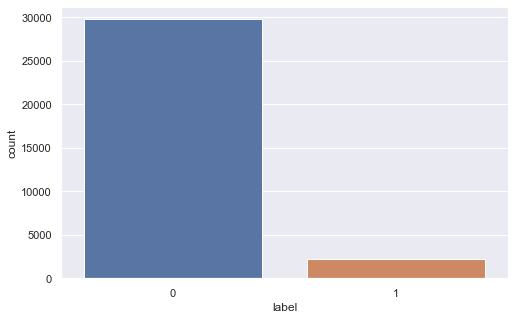

In [219]:
# Plotting the distribution for dataset.
sns.countplot(x='label', data=df_train)
# Storing data in lists.
#text, sentiment = list(df_train['tweet']), list(df_train['label'])

In [220]:
# Plotting the distribution for dataset based on label
fig = px.pie(df_train, names=df_train.label, hole=0.7, title='Tweets Classification',
             height=250, color_discrete_sequence=px.colors.qualitative.T10)
fig.update_layout(margin=dict(t=100, b=40, l=60, r=40), 
                  plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                  title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  )
fig.show()

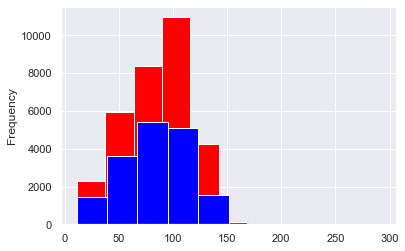

In [221]:
# checking the distribution of tweets in the data

length_train = df_train['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))
length_test = df_test['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

In [222]:
# adding a column to represent the length of the tweet

df_train['len'] = df_train['tweet'].str.len()
df_test['len'] = df_test['tweet'].str.len()

df_train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,102
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,116
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,74
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,143
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,87
9,10,0,@user @user welcome here ! i'm it's so #gr8 !,50


In [223]:
df_train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

#### Word Count per Label

In [224]:
df_train['word_counts'] = df_train['tweet'].str.split().str.len()
df_train.groupby('label')['word_counts'].mean()

label
0    13.091252
1    14.053078
Name: word_counts, dtype: float64

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

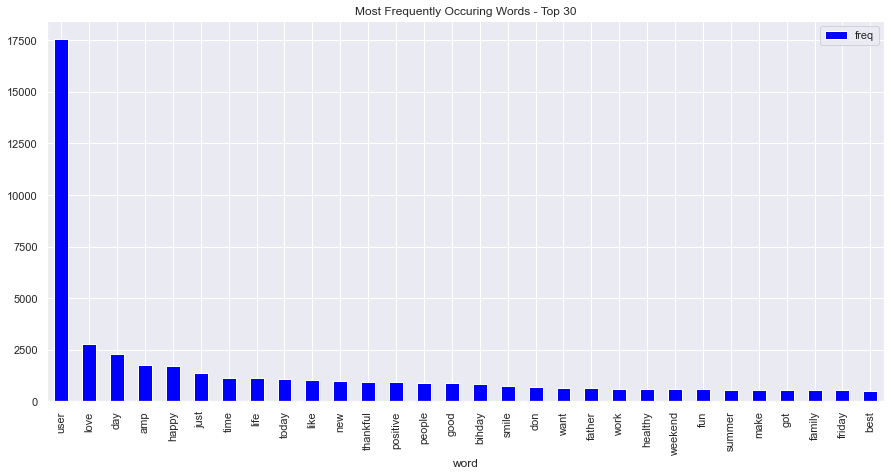

In [225]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


Text(0.5, 1.0, 'WordCloud - Vocabulary from Tweet Review')

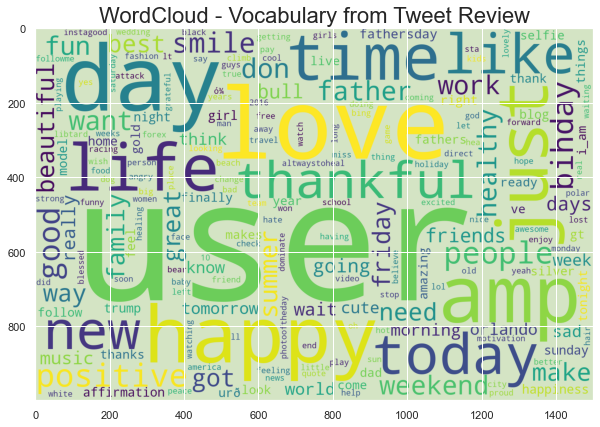

In [226]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = '#d4e4c4', width = 1500, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Tweet Review", fontsize = 22)

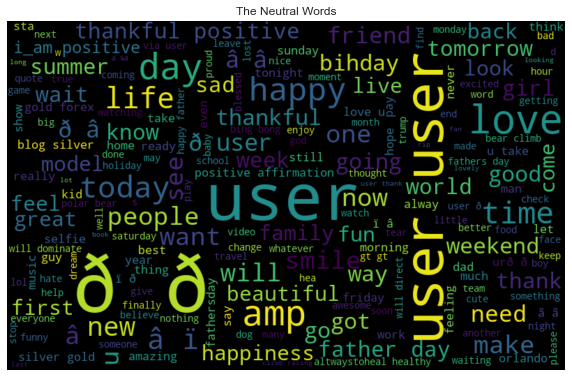

In [227]:
normal_words =' '.join([text for text in df_train['tweet'][df_train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

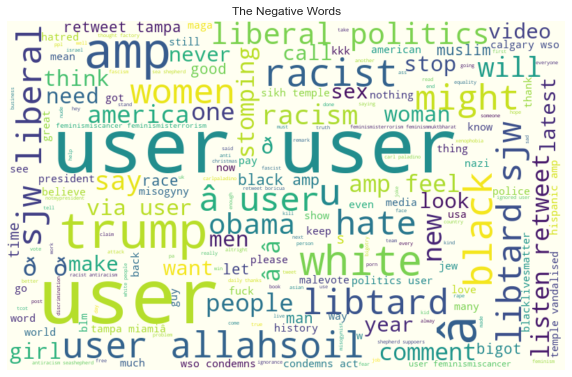

In [228]:
negative_words =' '.join([text for text in df_train['tweet'][df_train['label'] == 1]])

wordcloud = WordCloud(background_color = '#FFFFF1', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [229]:
# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(df_train['tweet'][df_train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df_train['tweet'][df_train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

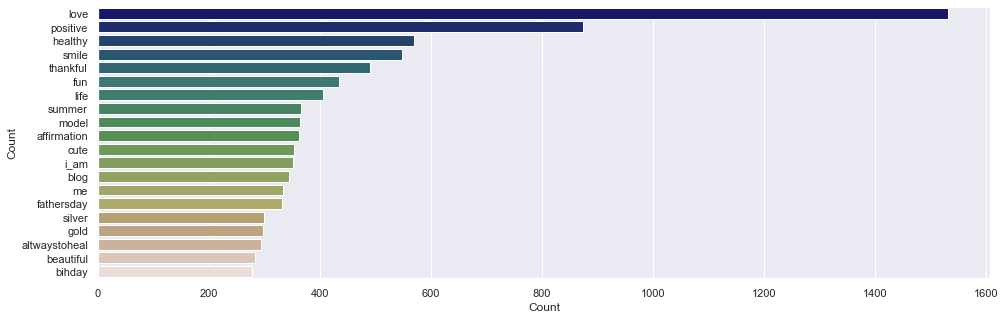

In [230]:
# Regular or positive Hashtag
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, y= "Hashtag", x= "Count",palette="gist_earth")
ax.set(ylabel = 'Count')
plt.show()

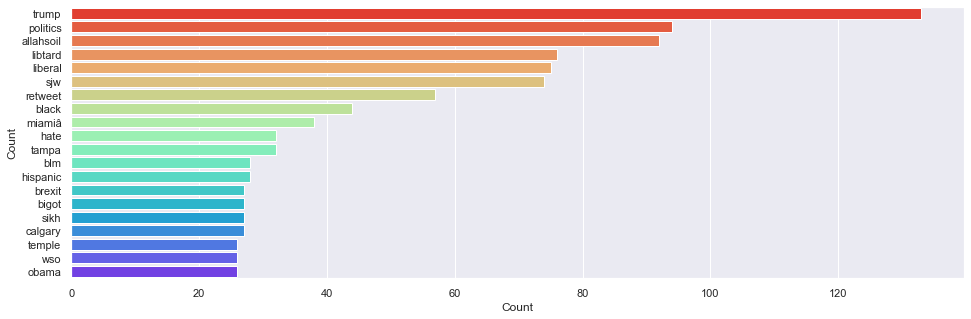

In [231]:
# Negative hashtag plot
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, y= "Hashtag", x= "Count",palette="rainbow_r")
ax.set(ylabel = 'Count')
plt.show()

In [232]:
# tokenizing the words present in the training set
tokenized_tweet = df_train['tweet'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(df_train['tweet']), epochs=20)

(6109793, 8411580)

In [233]:
model_w2v.wv.most_similar(positive = "happy")

[('saturday,', 0.5204711556434631),
 ('fasting,happy', 0.5186987519264221),
 ('holiday,always', 0.4880795180797577),
 ('tu', 0.48146852850914),
 ('yul', 0.4788038432598114),
 ('â\x9c\x8cð\x9f\x96\x90ð\x9f\x91\x80ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x8fð\x9f\x98\x81ð\x9f\x98\x9c',
  0.47839370369911194),
 ('jurgen', 0.4734443724155426),
 ('oppa', 0.4719197154045105),
 ('hoshi', 0.46927040815353394),
 ('#days13', 0.4635334312915802)]

In [234]:
model_w2v.wv.most_similar(positive = "excited")

[('omw', 0.5089465379714966),
 ('paicipate', 0.4956085979938507),
 ('disturbing,', 0.4910184144973755),
 ('album!', 0.4891231656074524),
 ('futureâ\x80¦', 0.4851732552051544),
 ('excited!!!', 0.4841609299182892),
 ('busy!', 0.4838663339614868),
 ('stoked', 0.4821558892726898),
 ('#singersongwriter', 0.4819033741950989),
 ('homeless', 0.481807142496109)]

In [235]:
model_w2v.wv.most_similar(positive = "family")

[('integral', 0.5915308594703674),
 ('bonding', 0.584186851978302),
 ('#lollipop', 0.5758114457130432),
 ('lawyer', 0.5757099390029907),
 ('#piggies', 0.5669927597045898),
 ('#finger', 0.5625028014183044),
 ('vacations.', 0.5577710270881653),
 ('#nomnom', 0.5553652048110962),
 ('\\', 0.5530065298080444),
 ('#puremichigan', 0.5485645532608032)]

In [236]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

In [237]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

[TaggedDocument(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 TaggedDocument(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 TaggedDocument(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 TaggedDocument(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 TaggedDocument(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 TaggedDocument(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandnogo'],

## Data Preprocesing

In [238]:
lst_stopwords = stopwords.words("english")
lst_stopwords
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    """

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def remove_pattern(input_txt):
    r = re.findall(r"@(\w+)", input_txt)
    for i in r:
        input_txt = re.sub(f'@{i}', '', input_txt)      
    return input_txt
    
def preprocess_tweet(row):
    text = row['clean_tweet1']
    text = p.clean(text)
    return text

def preprocessing_text(text):
     # Make lowercase
     text = text.str.lower()
     # Remove punctuation
     text = text.str.replace('[^\w\s]', '', regex=True)
     # Remove digits
     text = text.str.replace('[\d]+', '', regex=True)
     return text
pd.set_option('max_colwidth', 500)

In [239]:
# preprocesing of the data train
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: remove_pattern(x))
df_train['clean_tweet1'] = df_train["tweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df_train['clean_tweet1'] = df_train.apply(preprocess_tweet, axis=1)
df_train['clean_tweet1'] = preprocessing_text(df_train['clean_tweet1'])
df_train.tail()

,id,label,tweet,len,word_counts,clean_tweet,clean_tweet1
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸,68,5,ate isz that youuu?ðððððððððâ¤ï¸,ate user isz youuu
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,131,23,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,see nina turner airwave trying wrap mantle genuine hero like shirley chisolm shame imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad,63,13,listening to sad songs on a monday morning otw to work is sad,listening sad song monday morning otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act",67,10,"#sikh #temple vandalised in in #calgary, #wso condemns act",user sikh temple vandalised calgary wso condemns act
31961,31962,0,thank you @user for you follow,32,6,thank you for you follow,thank user follow


In [240]:
# Preprocessing of test dataset
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: remove_pattern(x))
df_test['clean_tweet1'] = df_test["tweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df_test['clean_tweet1'] = df_test.apply(preprocess_tweet, axis=1)
df_test['clean_tweet1'] = preprocessing_text(df_test['clean_tweet1'])
df_test.tail()

,id,tweet,len,clean_tweet,clean_tweet1
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,108,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factory leftright polarisation trump uselections leadership politics brexit blm gt
17193,49156,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,96,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feeling like mermaid hairflip neverready formal wedding gown dress mermaid
17194,49157,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",145,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",hillary campaigned today ohioomg amp used word like assetsampliability never clinton say theeword radicalization
17195,49158,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",104,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happy work conference right mindset lead cultureofdevelopment organization work mindset
17196,49159,"my song ""so glad"" free download! #shoegaze #newmusic #newsong",64,"my song ""so glad"" free download! #shoegaze #newmusic #newsong",song glad free download shoegaze newmusic newsong


In [241]:
#remove_pattern('@user when a father is dysfunctional and his son is a good')
df_train['tweet'][df_train['label'] == 0][:10]

0                                              @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1                         @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                                                                                bihday your majesty
3                                                             #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4                                                                                                             factsguide: society now    #motivation
5                               [2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
6                                                                          @user camping tomorrow @user @u

In [242]:
df_train.head()

,id,label,tweet,len,word_counts,clean_tweet,clean_tweet1
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,102,18,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user father dysfunctional selfish drag kid dysfunction run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,122,19,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked
2,3,0,bihday your majesty,21,3,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,86,14,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,5,0,factsguide: society now #motivation,39,4,factsguide: society now #motivation,factsguide society motivation


In [243]:
a = df_train['clean_tweet1'].str.cat(sep=' ')
words = word_tokenize(a)
word_dist = FreqDist(words)
dff = pd.DataFrame(word_dist.most_common(), 
                    columns=['Word', 'Frequency'])
dff['Word_Count'] = dff.Word.apply(len)
dff[:5]

,Word,Frequency,Word_Count
0,user,17500,4
1,love,2774,4
2,day,2768,3
3,happy,1691,5
4,u,1657,1


<AxesSubplot:xlabel='Frequency', ylabel='Word'>

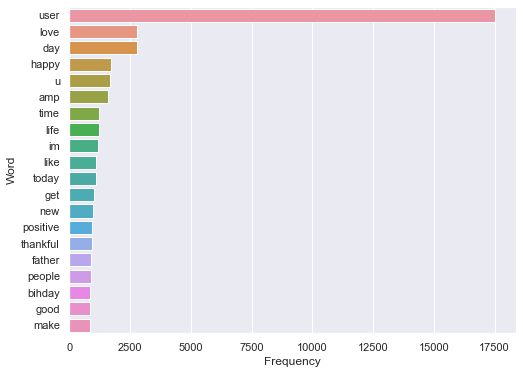

In [244]:
# Most Used Hashtahs and its frequency
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(y=dff['Word'][:20], x=dff['Frequency'][:20])

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

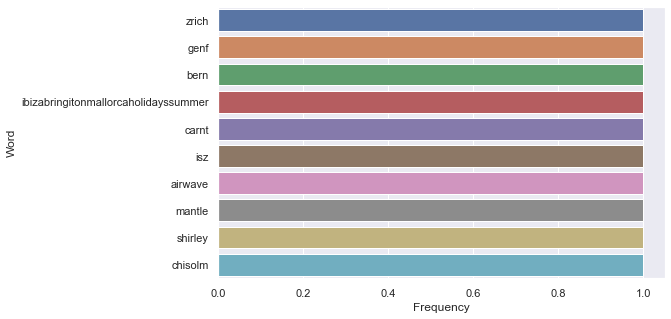

In [245]:
# Least Used Hashtag and its frequency                       )
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(y=dff['Word'].tail(10), x=dff['Frequency'].tail(10))

In [246]:
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag,download
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
df_train['token_tweet'] = df_train['clean_tweet1'].apply(tokenizer.tokenize)
df_train['postag_tweet'] = df_train['token_tweet'].apply(lambda x: pos_tag(x))


In [247]:
counts = Counter( tag for df_train['token_tweet'].iloc[1],  tag in df_train['postag_tweet'].iloc[1])
print(counts,df_train['tweet'].iloc[1])
df_train.head()

Counter({'NN': 8, 'VBP': 2, 'VBD': 2, 'RB': 1, 'JJ': 1, 'NNS': 1}) @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,label,tweet,len,word_counts,clean_tweet,clean_tweet1,token_tweet,postag_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,102,18,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user father dysfunctional selfish drag kid dysfunction run,"[user, father, dysfunctional, selfish, drag, kid, dysfunction, run]","[(user, NN), (father, RBR), (dysfunctional, JJ), (selfish, JJ), (drag, NN), (kid, NN), (dysfunction, NN), (run, VB)]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,122,19,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked,getthanked,"[(user, RB), (user, JJ), (thanks, NNS), (lyft, VBP), (credit, NN), (cant, NN), (use, NN), (cause, NN), (dont, NN), (offer, VBP), (wheelchair, NN), (van, NN), (pdx, NN), (disapointed, VBD), (getthanked, VBD)]"
2,3,0,bihday your majesty,21,3,bihday your majesty,bihday majesty,"[bihday, majesty]","[(bihday, NN), (majesty, NN)]"
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,86,14,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur,"[model, love, u, take, u, time, ur]","[(model, NN), (love, NN), (u, JJ), (take, VB), (u, JJ), (time, NN), (ur, JJ)]"
4,5,0,factsguide: society now #motivation,39,4,factsguide: society now #motivation,factsguide society motivation,"[factsguide, society, motivation]","[(factsguide, RB), (society, NN), (motivation, NN)]"


(31962, 1000)
(31962,)
1000


Text(0.5, 1.0, 'Sparse Matrix Sample')

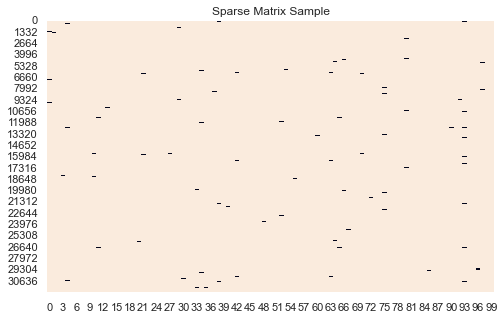

In [248]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1000)
bow = cv.fit_transform(df_train['clean_tweet1']).toarray()
y = df_train.iloc[:, 1]

print(bow.shape)
print(y.shape)
print(len(cv.get_feature_names()))
sns.heatmap(bow[:,np.random.randint(0,bow.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [260]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1000)
test_bow = cv.fit_transform(df_test['clean_tweet1']).toarray()

print(test_bow.shape)
print(len(cv.get_feature_names()))

(17197, 1000)
1000


In [268]:
# creating tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_train['clean_tweet1'])
tfidf.shape
test_tfidf = tfidf_vectorizer.fit_transform(df_test['clean_tweet1']).toarray()

print(test_bow.shape)
print(len(tfidf_vectorizer.get_feature_names()))

(17197, 1000)
1000


In [251]:
X_data, y_data = np.array(df_train['clean_tweet1']), np.array(df_train['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [282]:
# Generating word Embedding 
from gensim.models import Word2Vec

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
    
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
print(wordvec_df.shape)

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), df_train['clean_tweet1']))
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

(31962, 200)
Vocabulary Length: 5791


In [283]:
#wordvec_df

In [253]:
word2vec_model.wv.most_similar('good')

[('morning', 0.9149899482727051),
 ('aww', 0.8569595217704773),
 ('yeah', 0.8550517559051514),
 ('bing', 0.8398293256759644),
 ('bong', 0.8350027799606323),
 ('feeling', 0.8170211315155029),
 ('luck', 0.7940951585769653),
 ('saturday', 0.789486825466156),
 ('trained', 0.7861834168434143),
 ('grooming', 0.7833185791969299)]

In [254]:
print(len(word2vec_model.wv.get_vector('good')))
word2vec_model.wv.get_vector('good')

100


array([ 0.10408319,  0.38768908,  0.28134316,  0.19203374,  0.23733705,
       -1.2059612 , -0.34934762,  0.9094643 , -0.81541246,  0.33554158,
       -0.30073324, -1.186964  , -0.25466785,  0.11522131,  1.1429468 ,
        0.43386206,  0.2455663 ,  0.01737592,  0.7419438 , -1.2141801 ,
        0.12712567, -0.77386963,  0.6008101 , -0.2857307 , -0.08920614,
        0.05601311, -0.23143138,  0.10989339,  0.21351083, -0.5747562 ,
        0.8390124 , -0.36080587, -0.15098105, -0.68226963, -0.55767006,
        0.31143275, -0.11731023, -1.1125749 ,  0.3123342 , -0.95740885,
       -0.20997325,  0.69679683, -0.39239419,  1.2014626 ,  0.38060564,
        0.1343653 , -0.26662675, -0.8001328 ,  0.41981444,  1.0772493 ,
        0.5983971 ,  0.1604828 , -0.37929362, -0.02595145,  0.7763406 ,
       -0.38499194, -0.19312228,  0.8283814 , -0.56965196,  1.5102262 ,
        0.13363838,  0.18760034, -0.33374232,  0.8586405 , -0.36702213,
        0.9036646 ,  0.28571784,  0.03507087, -0.656794  ,  0.25

In [255]:
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

Tokenizer vocab length: 60000
X_train.shape: (30363, 60)
X_test.shape : (1599, 60)


In [256]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


### Now we have 100 new features, whereas in Bag of Words and TF-IDF we had 10000 features.

In [257]:
#doc2vec
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(df_train['clean_tweet1']), epochs=15)

100%|██████████| 31962/31962 [00:00<00:00, 3552437.78it/s]


In [258]:
tokenized_tweet = df_train.clean_tweet1.apply(lambda x: x.split())
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(df_train)):
    docvec_arrays[i,:] = model_d2v.dv[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(31962, 200)

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

- Logistic Regression
- Support Vector Machine
- RandomForest
- XGBoost

In [259]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [208]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 

# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5325542570951586

In [267]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(int)
df_test['label'] = test_pred_int
submission = df_test[['id','tweet','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file
submission.sample(5)

,id,tweet,label
9687,41650,i'll be on a flight to japan during game 7 #buthappy,0
12690,44653,"hello #edinburgh :-)) @ edinburgh, united kingdom",0
5059,37022,i wanted to donate my blood today. they dont accept jam ;-;,0
6232,38195,so what you're saying is you're basically law enforcement. got it.,0
6074,38037,#fathersday to this #100% absolute full time #committedâ¦,0


In [269]:
train_tfidf = tfidf[:31962,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain) 

prediction = lreg.predict_proba(xvalid_tfidf)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int) 

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5326184092940125

In [285]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain) 

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int)

0.5329153605015674

In [286]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:] 

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

lreg.fit(xtrain_d2v, ytrain) 

prediction = lreg.predict_proba(xvalid_d2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\kants\AppData\Local\Temp/ipykernel_10064/697985065.py:12: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/

0.31344612644701686